# Q1 Overview
## In this coding file:
- There are 11 comments including the answers of the 4 questions
- There are 4 graphs
- There are 3 regression tables

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linearmodels.panel import PanelOLS
import os

# Current Folder Path
folder_path = os.getcwd()

# Read csv files
cars_per_parking_sys = pd.read_csv(folder_path + "\\cars_per_parking_sys.csv")
cost_schedule = pd.read_csv(folder_path + "\\cost_schedule.csv")
raw_park = pd.read_csv(folder_path + "\\raw_park_sys_info_df.csv")

# Q2 Data Cleaning

In [2]:
# Merge cars_per_parking_sys and cost_schedule
merged_df = pd.merge(cars_per_parking_sys, cost_schedule, on='park_sys_id')

# Fill missing values in column "park_sys_type"
merged_df['park_sys_type'] = merged_df.groupby('park_sys_id')['park_sys_type'].transform(lambda x: x.ffill().bfill())

# Fill missing values in column "num_vehicles"
## Replace symbols with ":" in column "time" and "switching_time", and Change them to HH:MM format
merged_df['time'] = merged_df['time'].replace(r'\W+', ':', regex=True)
merged_df['switching_time'] = merged_df['switching_time'].replace(r'\W+', ':', regex=True)
merged_df['time'] = pd.to_datetime(merged_df['time'], format='%H:%M')
merged_df['switching_time'] = pd.to_datetime(merged_df['switching_time'], format='%H:%M')

## Fill missing values with linear interpolation
merged_df = merged_df.sort_values(['park_sys_id', 'time'])
merged_df['scornum_vehiclese'] = merged_df.groupby('park_sys_id')['num_vehicles'].transform(lambda x: x.interpolate())

# Calculate the real_cost
merged_df['real_cost'] = merged_df.apply(lambda row: row['pre_switch_cost']
                                         if row['time'] < row['switching_time'] 
                                         else row['post_switch_cost'], axis=1)

## Comment 1 (Answers of Question 2)
### To enhance the data quality, the changes I made compared to the original merged data are:
- I filled out the missing values in the park_sys_type column based on the prefix of the parking system ID ("psres_xx" is denoted as "residential", "pscom_xx" is denoted as "commercial").
- I filled out the missing values in the num_vehicles column with the average of vehicles in the minutes before and after.
- I standardized the time column to be in the format of "HH:MM" because I found some symbols in the time column that were not in the "HH:MM" format, e.g., HH,MM.
- Finally, I updated the original merged data dataframe for the next step.

## Comment 2
- As for the missing values in the num_vehicles column, there is another alternative approach to calculate average values by using simple average of vehicles in the minutes before and after, but there is a potential problem that the average values are not accurate because the data either before or after is missing. so I just posted the coding here but not used it in my final code.

   #### Convert the "num_vehicles" column to numeric by removing non-numeric characters
    merged_df_copy['num_vehicles'] = pd.to_numeric(merged_df_copy['num_vehicles'], errors='coerce')

   #### Iterate over each row in the DataFrame
    for index, row in merged_df_copy.iterrows():
        if pd.isnull(row['num_vehicles']):
            before_value = merged_df_copy['num_vehicles'].iloc[index - 1]
            after_value = merged_df_copy['num_vehicles'].iloc[index + 1]

            # Check if either value is blank (NaN) or equal to 0
            if pd.isnull(before_value) or pd.isnull(after_value) or before_value == 0 or after_value == 0:
                print(f"Note: Missing value at index {index} cannot be filled due to insufficient data.")
            else:
                # Calculate the average of the before and after values
                avg_value = (before_value + after_value) / 2

                # Fill missing value with the average
                merged_df_copy.at[index, 'num_vehicles'] = avg_value


# Q3 Data Exploration

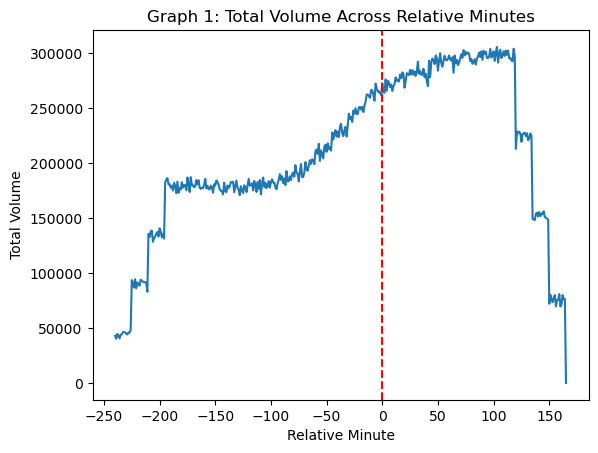

In [3]:
# Calculate relative_minute
merged_df['relative_minute'] = (merged_df['time'] - merged_df['switching_time']).dt.total_seconds() / 60

# Calculate the number of vehicles of each relative_minute
total_volume = merged_df.groupby('relative_minute')['num_vehicles'].sum()

# Create the plot
plt.plot(total_volume.index, total_volume.values)
plt.axvline(x=0, color='red', linestyle='--')  # Vertical line at the 0-minute mark

# Set the labels and title
plt.xlabel('Relative Minute')
plt.ylabel('Total Volume')
plt.title('Graph 1: Total Volume Across Relative Minutes')

# Display the plot
plt.show()

## Comment 3 (Sub-answers 1 to Question 3)
### Graph 1 "Total Volume Across Relative Minutes" represents the aggregate number of cars parked across all parking systems over time, relative to the minute when the switch to free parking occurred (marked by the vertical red line at minute 0)
### Key observations:
- Initially, the total volume increases, but at a slower rate compared to before the switch to free parking, and it reaches its peak even after the fare switch.
- There is a significant and sudden drop in the total volume around the 120th relative minute, indicating that many cars exited the parking facilities.
### Key insights:
- The parking lot is likely to be more crowded towards the end of the day as people tend to leave the parking area earlier in the morning and evening.
- The drop in total volume after the switch to free parking suggests that many drivers were aware of the upcoming change to free parking and timed their departures accordingly to minimize parking costs.
- However, factors such as people's personal schedules or the time they finish work seem to have a more significant impact on drivers leaving the parking lot than the zero-cost parking initiative.
### Future directions for analysis:
It would be interesting to further investigate the relationship between the total volume and other factors, such as weather conditions, seasonality, or the popularity of different parking lots. Exploring these factors could provide additional insights into the patterns and dynamics of parking behavior.

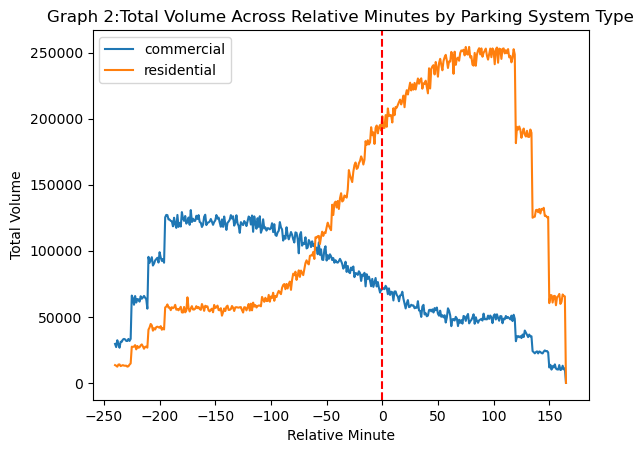

In [4]:
# Group the data by park_sys_id, relative_minute, and calculate the total volume
total_volume = merged_df.groupby(['park_sys_type', 'relative_minute'])['num_vehicles'].sum()

# Get the unique park_sys_id values
park_sys_type = merged_df['park_sys_type'].unique()

# Iterate over each park_sys_id and plot a line for each type
for park_sys_type in park_sys_type:
    if park_sys_type in total_volume.index.get_level_values('park_sys_type'):
        volume = total_volume[park_sys_type]
        plt.plot(volume.index, volume.values, label=park_sys_type)

# Add a vertical line at the 0-minute mark
plt.axvline(x=0, color='red', linestyle='--')

# Set the labels and title
plt.xlabel('Relative Minute')
plt.ylabel('Total Volume')
plt.title('Graph 2:Total Volume Across Relative Minutes by Parking System Type')

# Add a legend
plt.legend()

# Display the plot
plt.show()

## Comment 4 (Sub-answers 2 of Question 3)
### Graph 2 "Total Volume Across Relative Minutes by Parking System Type" displays the total volume of parked cars categorized into commercial and residential parking systems. It illustrates how the parking volume for each type evolves over time relative to the switch to free parking.
### Key observations:
- For commercial parking slot, a gradual decline in the total volume even before the switch to free parking is observed, with a significant drop after the switch.
- For residential parking slot, the total volume increases steadily even after the switch to free parking, and then decreases sharply around 120 relative minutes, which is aligned with the overall trend displayed in Graph 1.
- Compared to residential systems, commercial parking systems experience a more significant increase in volume at the earlier in the day and reached the peak earlier before fare switching to zero.
### Key insights:
- The switch in parking fees does not seem to be the sole determining factor impacting the changes in the total number of parked cars throughout the day. The zero-fare switching initiative is one of the contributing factors to the sharp changes in the number of cars across parking lots, as reflected in the overall pattern observed in Graph 1.
- The differences in patterns between the two types of parking lots are significant and can be attributed to various factors, such as:
  - The nature of the facilities: Commercial facilities primarily serve businesses, resulting in a later drop in demand compared to residential facilities.
  - The demand for parking: Commercial facilities may experience higher utilization during peak hours, leading to increased parking demand.
  - The parking policy: Commercial facilities may have more stringent parking policies or access restrictions, resulting in more predictable schedules or pricing structures.
  - The parking infrastructure: Commercial facilities may have more parking spaces or dedicated parking lots, enabling more efficient parking management.

## Comment 5 (Overall Answers of Question 3)
- Overall, given the nature of the data and the observed patterns in the two graphs, it is evident that there is a significant and noticeable decrease in the total volume of parked cars across all parking systems as the day progresses (positive relative minutes), particularly towards the end of the day. This trend can be attributed to the transition of many parking facilities to free parking later in the day. Furthermore, in future analysis, it would be worthwhile to also consider the earlier hours of the day, as numerous parking facilities may also switch to free parking in the early morning.

- However, it is crucial to acknowledge that while the zero-fare switch initiative may be the dominant factor contributing to the dramatic changes in the number of cars in each parking lot, it is not the exclusive factor. Additional factors come into play, influencing the contrasting patterns observed in the total volume between commercial and residential parking systems. Conducting further analysis and exploration of these factors can provide deeper insights into the dynamics of parking behavior and the overall impact of parking policies in various contexts.

# Q4 Estimation

In [5]:
# 4.1 
merged_df = merged_df.set_index(['park_sys_id', 'relative_minute'])

# Perform panel OLS regression with control variables, taking into account the panel nature of our data
model1 = PanelOLS.from_formula('num_vehicles ~ real_cost', merged_df)
results1 = model1.fit()

# Print regression results
print(results1)

                          PanelOLS Estimation Summary                           
Dep. Variable:           num_vehicles   R-squared:                        0.3148
Estimator:                   PanelOLS   R-squared (Between):              0.6335
No. Observations:               35376   R-squared (Within):              -0.8221
Date:                Sun, Mar 31 2024   R-squared (Overall):              0.3148
Time:                        23:56:37   Log-likelihood                -3.241e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   1.625e+04
Entities:                         100   P-value                           0.0000
Avg Obs:                       353.76   Distribution:                 F(1,35375)
Min Obs:                       346.00                                           
Max Obs:                       359.00   F-statistic (robust):          1.625e+04
                            

c:\Users\ji1wang\AppData\Local\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


## Comment 6 (Answers of Question 4.1)
### In the first regression summary, 
- The coefficient of 50.543 for the "real_cost" variable, with a t-statistic of 127.48 and a p-value of 0.0000 indicates that the coefficient is highly statistically significant.
- The coefficient of 50.543 suggests that for every one-unit increase in the "real_cost" (price), the predicted number of parked cars decreases by approximately 50.543 units, holding all other factors constant. In other words, higher parking prices are associated with lower parking demand.


## Comment 7( Answers of Question 4.2) 
- No, the regression alone is not sufficient to establish a causal effect of price on parking demand. There could be potential endogeneity issues, such as reverse causality (parking demand influencing prices) or omitted variable bias (unobserved factors affecting both price and demand). Additionally, the regression model may not adequately capture the true relationship between price and demand, especially if it is non-linear or involves complex interactions.
- To establish a more reliable causal effect, additional analyses and approaches would be needed, such as exploiting exogenous policy changes, natural experiments, or instrumental variables that affect prices but are plausibly unrelated to other factors influencing demand. Robustness checks, sensitivity analyses, and alternative modeling approaches could also be employed.

## 4.3 Add dummy variable


In [6]:
merged_df['park_sys_type'] = pd.Categorical(merged_df['park_sys_type'])
merged_df['park_sys_type_dummy'] = pd.get_dummies(merged_df['park_sys_type'], drop_first=True)

model2 = PanelOLS.from_formula('num_vehicles ~ real_cost + park_sys_type_dummy', merged_df)
results2 = model2.fit()

# Print regression results
print(results2)

                          PanelOLS Estimation Summary                           
Dep. Variable:           num_vehicles   R-squared:                        0.6491
Estimator:                   PanelOLS   R-squared (Between):              0.9139
No. Observations:               35376   R-squared (Within):              -0.2958
Date:                Sun, Mar 31 2024   R-squared (Overall):              0.6491
Time:                        23:56:37   Log-likelihood                -3.123e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   3.272e+04
Entities:                         100   P-value                           0.0000
Avg Obs:                       353.76   Distribution:                 F(2,35374)
Min Obs:                       346.00                                           
Max Obs:                       359.00   F-statistic (robust):          3.272e+04
                            

c:\Users\ji1wang\AppData\Local\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


## Comment 8 (Answers of Question 4.3)
### In the second regression summary,
- The coefficient of 26.854 for "real_cost" remains statistically significant but reduced compared to the previous analysis without considering type of parking systems, suggesting that after controlling for parking system type, a one-unit increase in price is associated with a decrease of approximately 26.854 units in the number of parked cars.
- The coefficient of 2500.0 for "park_sys_type_dummy" indicates that, on average, the predicted number of parked cars is 2500.0 units higher for one of the parking system types (likely commercial) compared to the reference category (likely residential), holding all other factors constant.
- The p-value for "park_sys_type_dummy" is 0.0000, indicating a significant difference in the average number of parked cars between the two parking system types.
- Overall, the inclusion of the dummy variable for parking system type in the regression model provides additional evidence that the price of parking has an effect on the number of parked cars. However, endogeneity concerns and potential non-linearities in the relationship may still exist.

## 4.4 Add a continuous variable


In [7]:
from datetime import datetime

# Convert the time column to datetime object
merged_df['time'] = pd.to_datetime(merged_df['time'], format='%Y-%m-%d %H:%M:%S')

# Convert the time to minutes
merged_df['minute_of_day'] = merged_df['time'].dt.hour * 60 + merged_df['time'].dt.minute

# Perform regression analysis
model3 = PanelOLS.from_formula('num_vehicles ~ real_cost + park_sys_type_dummy + minute_of_day', merged_df)
results3 = model3.fit()

# Print regression results
print(results3)


                          PanelOLS Estimation Summary                           
Dep. Variable:           num_vehicles   R-squared:                        0.8009
Estimator:                   PanelOLS   R-squared (Between):              0.9998
No. Observations:               35376   R-squared (Within):               0.0911
Date:                Sun, Mar 31 2024   R-squared (Overall):              0.8009
Time:                        23:56:37   Log-likelihood                -3.022e+05
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                   4.743e+04
Entities:                         100   P-value                           0.0000
Avg Obs:                       353.76   Distribution:                 F(3,35373)
Min Obs:                       346.00                                           
Max Obs:                       359.00   F-statistic (robust):          4.743e+04
                            

c:\Users\ji1wang\AppData\Local\anaconda3\Lib\site-packages\linearmodels\panel\model.py:1214: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


## Comment 9 (Answers of Question 4.4)
### In the third regression summary,
- The coefficient of -4.5115 for "real_cost"(Price) remains statistically significant, but the magnitude has decreased compared to the previous models.This coefficient that is changed from positive to negative after including "minute_of_day" could be due to the correlation between pricing strategies and time of day. For example, parking facilities may adjust prices based on expected demand patterns throughout the day. By explicitly controlling for the time of day, the model can better isolate the effect of price on demand, leading to a more accurate estimate of the price coefficient.
- The "minute_of_day" coefficient (1.9185) means that for every minute increase in the day, the predicted number of parked cars increases by approximately 1.9185 units, holding all other factors constant. This positive coefficient suggests that parking demand increases as the day progresses, which could be due to factors such as commuters arriving for work or increased business activity.
- Overall, the inclusion of fixed effects and time controls helps account for potential confounding factors and provides a more nuanced understanding of the relationship between price and parking demand. However, caution should still be exercised when making causal claims, and additional analyses or estimation techniques may be required to further address endogeneity concerns.

# Q5 Big Data Processing

## Expore datasets

In [8]:
print(cars_per_parking_sys)

      park_sys_id park_sys_type  num_vehicles   time
0         psres_1   residential        1212.0  14:00
1         psres_2   residential        1134.0  14:00
2         psres_3   residential        1137.0  14:00
3         psres_4   residential        1392.0  14:00
4         psres_5   residential        1126.0  14:00
...           ...           ...           ...    ...
36095    pscom_46    commercial           0.0  20:00
36096    pscom_47    commercial           0.0  20:00
36097    pscom_48    commercial           0.0  20:00
36098    pscom_49    commercial           0.0  20:00
36099    pscom_50    commercial           0.0  20:00

[36100 rows x 4 columns]


In [9]:
print(raw_park)

        park_system       vehicle_ids timestamp
0          psres_33  3UY4C3iJ3vtWqTK6     14:00
1          psres_33  RulVeq1QfpY9j7Nc     14:00
2          psres_33  fePrjHJPqLc4RtPt     14:00
3          psres_33  TvfHsGtyrX3xqvjl     14:00
4          psres_33  tXiKDcZIfMaOl7X3     14:00
...             ...               ...       ...
4229813    psres_36  PBNU6CRfNeVK3VQb     19:59
4229814    psres_36  fqzSevo5nIaOP6iD     19:59
4229815    psres_36  TXpKGd7jpj7HhU4Z     19:59
4229816    psres_36  iinxlWTkRyrdHBjJ     19:59
4229817    psres_36          LogError     20,00

[4229818 rows x 3 columns]


In [10]:
filtered_99 = raw_park[raw_park['vehicle_ids'] == '-99']
print("Number of rows: ", filtered_99.shape[0])
print(filtered_99)

Number of rows:  28
        park_system vehicle_ids timestamp
48750      psres_33         -99     14:43
127105     psres_33         -99     15:51
180297     psres_33         -99     16:28
373383     psres_33         -99     17:36
693346     psres_33         -99     18:46
703720     psres_33         -99     18:49
996440     psres_33         -99     19:48
1075021    psres_34         -99     14:20
1079313    psres_34         -99     14:25
1105625    psres_34         -99     14:49
1191128    psres_34         -99     16:03
1322839    psres_34         -99     17:07
1540010    psres_34         -99     18:03
1549046    psres_34         -99     18:06
1562416    psres_34         -99     18:10
1591359    psres_34         -99     18:17
1650165    psres_34         -99     18:30
1947757    psres_34         -99     19:30
2003967    psres_34         -99     19:42
2138338    psres_35         -99     14:42
2159801    psres_35         -99     15:02
2181388    psres_35         -99     15:20
3226098    psr

In [11]:
filtered_log_error = raw_park[raw_park['vehicle_ids'] == 'LogError']
print("Number of rows: ", filtered_log_error.shape[0])
print(filtered_log_error)

Number of rows:  14
        park_system vehicle_ids timestamp
11090      psres_33    LogError     14:10
11091      psres_33    LogError     14:11
11092      psres_33    LogError     14:12
11093      psres_33    LogError     14:13
11094      psres_33    LogError     14:14
11095      psres_33    LogError     14:15
11096      psres_33    LogError     14:16
11097      psres_33    LogError     14:17
11098      psres_33    LogError     14:18
11099      psres_33    LogError     14:19
1052177    psres_33    LogError     20:00
2090552    psres_34    LogError     20:00
3165287    psres_35    LogError     20:00
4229817    psres_36    LogError     20,00


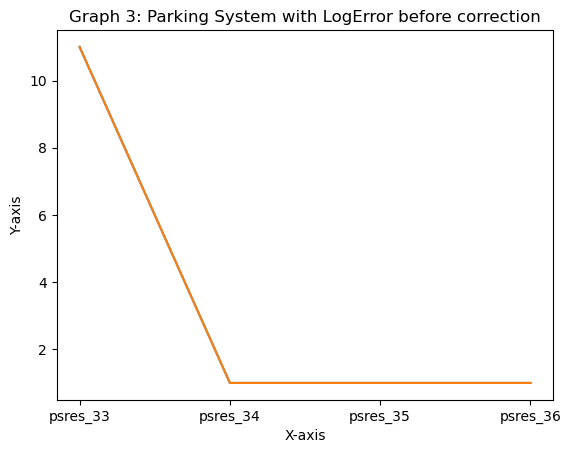

In [12]:
# Group by 'park_system' and get the count of each park system
y = filtered_log_error.groupby('park_system').count()

# Get the sorted values of x
x = y.index.sort_values()

# Create a line plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Graph 3: Parking System with LogError before correction')

# Display the line graph
plt.show()

In [13]:
filtered_short_ids = raw_park[(raw_park['vehicle_ids'].str.len() < 16) & (raw_park['vehicle_ids'] != '-99') & (raw_park['vehicle_ids'] != 'LogError')]
print(filtered_short_ids)

      park_system vehicle_ids timestamp
11100    psres_33          vM     14:20
11101    psres_33          Za     14:20
11102    psres_33          9d     14:20
11103    psres_33          hZ     14:20
11104    psres_33          vQ     14:20
...           ...         ...       ...
21087    psres_33          w9     14:20
21088    psres_33          rz     14:20
21089    psres_33          ry     14:20
21090    psres_33          8O     14:20
21091    psres_33          Aa     14:20

[9989 rows x 3 columns]


In [14]:
missing_values = raw_park.isnull().sum()
print(missing_values)

park_system    0
vehicle_ids    3
timestamp      0
dtype: int64


In [15]:
missing_values_df = raw_park[raw_park.isnull().any(axis=1)]
print(missing_values_df)

      park_system vehicle_ids timestamp
13307    psres_33         NaN     14:20
14352    psres_33         NaN     14:20
19200    psres_33         NaN     14:20


## Process data

In [16]:
def process_df(df):
    # Convert 'LogError' to '-99'
    df['vehicle_ids'] = df['vehicle_ids'].apply(lambda x: '-99' if x == 'LogError' else x)
    
    # Remove records where vehicle_ids length is shorter than 16, except '-99'
    df = df[(df['vehicle_ids'].str.len() >= 16) | (df['vehicle_ids'] == '-99')]
    
    return df

processed_raw = process_df(raw_park)

print("Number of rows: ", processed_raw.shape[0])
print(processed_raw)

Number of rows:  4219826
        park_system       vehicle_ids timestamp
0          psres_33  3UY4C3iJ3vtWqTK6     14:00
1          psres_33  RulVeq1QfpY9j7Nc     14:00
2          psres_33  fePrjHJPqLc4RtPt     14:00
3          psres_33  TvfHsGtyrX3xqvjl     14:00
4          psres_33  tXiKDcZIfMaOl7X3     14:00
...             ...               ...       ...
4229813    psres_36  PBNU6CRfNeVK3VQb     19:59
4229814    psres_36  fqzSevo5nIaOP6iD     19:59
4229815    psres_36  TXpKGd7jpj7HhU4Z     19:59
4229816    psres_36  iinxlWTkRyrdHBjJ     19:59
4229817    psres_36               -99     20,00

[4219826 rows x 3 columns]


## Prcoess raw data in Chunk size of 200K

In [17]:
def process_raw_park(input_file, output_file, chunksize):
    
    first_chunk = True

    # Read the input file in chunks
    for chunk in pd.read_csv(input_file, chunksize=chunksize):
        # Process the chunk
        processed_chunk = process_df(chunk)

        # If it's the first chunk, write it to the output file with headers
        if first_chunk:
            processed_chunk.to_csv(output_file, mode='w', index=False)
            first_chunk = False
        # Otherwise, append it to the output file without headers
        else:
            processed_chunk.to_csv(output_file, mode='a', index=False, header=False)

process_raw_park('raw_park_sys_info_df.csv', 'new_cars_per_parking_sys.csv', 200000)

## Show new cars per parking statistcs

In [18]:
new_cars_per_park = pd.read_csv('new_cars_per_parking_sys.csv')

# Show statistics
print(new_cars_per_park.describe())

       park_system vehicle_ids timestamp
count      4219826     4219826   4219826
unique           4     4219785       390
top       psres_35         -99     18:59
freq       1074735          42     21177


In [19]:
filtered_log_error_pro = new_cars_per_park [new_cars_per_park ['vehicle_ids'] == '-99']
print("Number of rows: ", filtered_log_error_pro.shape[0])
print(filtered_log_error_pro) 


Number of rows:  42
        park_system vehicle_ids timestamp
11090      psres_33         -99     14:10
11091      psres_33         -99     14:11
11092      psres_33         -99     14:12
11093      psres_33         -99     14:13
11094      psres_33         -99     14:14
11095      psres_33         -99     14:15
11096      psres_33         -99     14:16
11097      psres_33         -99     14:17
11098      psres_33         -99     14:18
11099      psres_33         -99     14:19
38758      psres_33         -99     14:43
117113     psres_33         -99     15:51
170305     psres_33         -99     16:28
363391     psres_33         -99     17:36
683354     psres_33         -99     18:46
693728     psres_33         -99     18:49
986448     psres_33         -99     19:48
1042185    psres_33         -99     20:00
1065029    psres_34         -99     14:20
1069321    psres_34         -99     14:25
1095633    psres_34         -99     14:49
1181136    psres_34         -99     16:03
1312847    psr

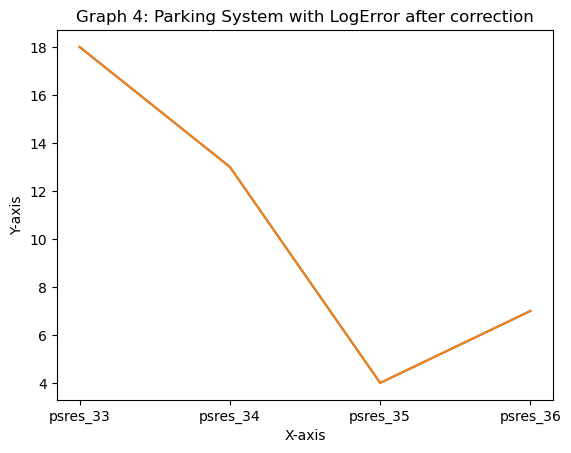

In [20]:
# Group by 'park_system' and get the count of each park system
y = filtered_log_error_pro.groupby('park_system').count()

# Get the sorted values of x
x = y.index.sort_values()

# Create a line plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Graph 4: Parking System with LogError after correction')

# Display the line graph
plt.show()

## Comment 10 (Answers of Question 5.1)
- When comparing the trends in Graph 4 and Graph 5, we can see the number of logerrors in psres_33 parking system are the largest among these 4 parking systems in both "-99" and "LogError" cases. 

## Comment 11 (Answers of Question 5.2)
### The reasons of choosing incremental processing: 
- Instead of processing the entire dataset at once, adopting an incremental processing approach to process the data in smaller chunks or batches, enabling efficient processing of the data in a step-by-step manner, updating analysis or model iteratively with new data
